In [2]:
import sympy
sympy.init_printing()

(u_max, u_star, rho_max, 
 rho_star, A, B) = sympy.symbols('u_max u_star rho_max rho_star A B')

In [3]:
eq1 = sympy.Eq(0, u_max*rho_max*(1 - A*rho_max-B*rho_max**2))
eq2 = sympy.Eq(0, u_max*(1 - 2*A*rho_star-3*B*rho_star**2))
eq3 = sympy.Eq(u_star, u_max*(1 - A*rho_star - B*rho_star**2))

In [4]:
eq1

In [5]:
eq2

In [6]:
eq3

In [6]:
eq2 - 3*eq3

In [8]:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4

In [9]:
eq4.simplify()

In [10]:
eq4

In [11]:
eq4.expand()

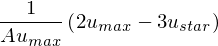

In [12]:
rho_sol = sympy.solve(eq4,rho_star)[0]
rho_sol

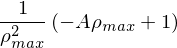

In [13]:
B_sol = sympy.solve(eq1,B)[0]
B_sol

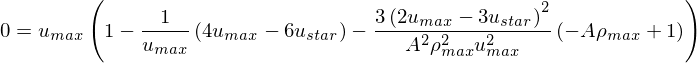

In [14]:
quadA = eq2.subs([(rho_star,rho_sol),(B,B_sol)])
quadA

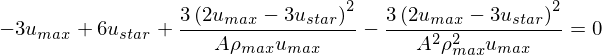

In [15]:
quadA.simplify()

In [16]:
A_sol = sympy.solve(quadA, A)

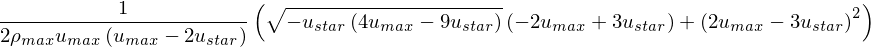

In [17]:
A_sol[0]

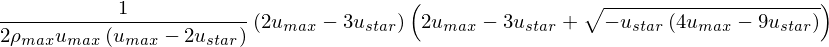

In [18]:
A_sol[1]

In [21]:
Value_A1 = A_sol[0].evalf(subs={u_star: 1.5, u_max:2.0, rho_max:15.0})
Value_A1

In [22]:
Value_A2 = A_sol[1].evalf(subs={u_star:1.5, u_max:2.0,rho_max:15.0})
Value_A2

In [23]:
Value_B = B_sol.evalf(subs={rho_max:15.0,A:Value_A2})# choosed Value_A > 0
Value_B

In [24]:
################################################################

In [25]:
(u_max,rho,A,B,f)=sympy.symbols('u_max rho A B f')
eqFdiff = sympy.Eq(f(rho), u_max*(1-A*rho-B*rho**2)+u_max*rho*(-A-2*B*rho))
eqFdiff

In [26]:
eqFdiff.expand()

In [27]:
f=sympy.Eq(0,u_max*(1-A*rho-B*rho**2)+u_max*rho*(-A-2*B*rho))
f

In [28]:
f.expand()

In [29]:
rho_sol = sympy.solve(f,rho)

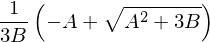

In [30]:
rho_sol[0]

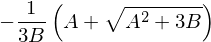

In [31]:
rho_sol[1]

In [32]:
print(Value_A2)
print(Value_B)

0.0197690110272418
0.00312651037596166


In [33]:
Value_rho1=rho_sol[0].evalf(subs={A:Value_A2,B:Value_B})
Value_rho1

In [34]:
Value_rho2=rho_sol[1].evalf(subs={A:Value_A2, B:Value_B})
Value_rho2

In [35]:
# rho : the density of the fluid
# u   : the velocity of the fluid
# p   : the pressure of the fluid
# e_T : the specific total energy

In [36]:
%matplotlib inline
import numpy

In [37]:
# initial condition on the left side
ICL   = [1.0,0.0,100000.0]
rho_L = ICL[0]
u_L   = ICL[1]
p_L   = ICL[2]

In [38]:
# initial condition on the right side
ICR   = [0.125, 0.0, 10000.0]
rho_R = ICR[0]
u_R   = ICR[1]
p_R   = ICR[2]

In [39]:
nx = 81
dx = 0.25
dt = 0.0002
gamma = 1.4
T = 0.01 #final time in question "calculate at time t = 0.01 s
nt = int(T/dt)+1

In [40]:
def search_initial(nx, initial_left, initial_right):
    
    initial_condition = initial_right*numpy.ones(nx)
    initial_condition[:int((nx-1)*10./20.)]=initial_left
    return initial_condition

In [41]:
def computeU(rho, u, p):
    
    U = numpy.empty([nx,3])
    
    for i in range(nx):
        
        e = p[i]/((gamma-1)*rho[i])
        e_T = e + (u[i]**2)/2
        U[i] = [rho[i], rho[i]*u[i], rho[i]*e_T]
        
    return U

In [42]:
def computeF(U):
    F = numpy.empty([nx,3])
    
    for i in range(nx):
        
        U_dum = U[i]
        
        U1 = U_dum[0]
        U2 = U_dum[1]
        U3 = U_dum[2]
        
        F[i] = [U2, (U2**2)/U1+(gamma-1)*(U3-0.5*(U2**2)/U1),
               (U3+(gamma-1)*(U3-0.5*(U2**2)/U1))*U2/U1]
        
    return F

In [43]:
def Search_U_star(U,F):
    U_star = numpy.zeros_like(U)
    
    for i in range(1,nx):
        
        U_star[i-1]=0.5*(U[i]+U[i-1])-dt/(2*dx)*(F[i]-F[i-1])
        
    return U_star

In [44]:
def Search_U_next(U,F_dum):
    
    U_next = numpy.empty([nx,3])
    K2     = numpy.zeros([nx,3])
    K1     = numpy.zeros([nx,3])
    
    U_next[0]  = U[0]
    U_next[-1] = U[-1]
    
    for i in range (1,nx-1):
        
        U_next[i]=U[i]-dt/dx*(F_dum[i]-F_dum[i-1])
        
    return U_next

In [45]:
rho_initial = numpy.empty(nx)
u_initial   = numpy.empty(nx)
p_initial   = numpy.empty(nx)
U_real      = numpy.empty([nx,3])

rho_initial = search_initial(nx, rho_L, rho_R)
u_initial   = search_initial(nx, u_L, u_R)
p_initial   = search_initial(nx, p_L, p_R)
U_real      = computeU(rho_initial, u_initial, p_initial)

In [46]:
F_n_prev = numpy.empty([nx,3])
U_dummy  = numpy.empty([nx,3])
F_dummy  = numpy.empty([nx,3])
U_n      = numpy.empty([nx,3])
U_49     = numpy.empty([nx,3])

In [47]:
# initial condition for U (n=0 -> U_0)
U_n = U_real

In [50]:
#calculate at time n=1 until n=49
for n in range(1, nt-1):
    U = U_n
    F_n_prev = computeF(U)
    U_dummy = Search_U_star(U,F_n_prev)
    F_dummy = computeF(U_dummy)
    U_n = Search_U_next(U, F_dummy)
    
U_49 = U_n

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


In [51]:
#calculate at time n=50 -> t=0.01 s
F = computeF(U_49)
U_dummy = Search_U_star(U_49, F)
F_dummy = computeF(U_dummy)
U_final = Search_U_next(U_49, F_dummy)

print('Output Final\n')

for i in range(nx):
    Out = U_final[i]
    
    print(i)
    print(U_final[i])
    
    if i == 50:
        U1 = Out[0]
        U2 = Out[1]
        U3 = Out[2]
        
        velocity = U2/U1
        pressure = (gamma -1)*(U3-0.5*(U2**2)/U1)
        density = U1
        
        print('velocity =', velocity)
        print('pressure =', pressure)
        print('density =', density)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


Output Final

0
[  1.00000000e+00   0.00000000e+00   2.50000000e+05]
1
[  8.57846022e-01   4.90724478e+01   2.02401180e+05]
2
[  9.03745687e-01   3.36180124e+01   2.17711016e+05]
3
[  8.59652254e-01   4.79045452e+01   2.03555874e+05]
4
[  8.56503319e-01   4.87956159e+01   2.02679316e+05]
5
[  8.35537609e-01   5.51501239e+01   1.96215153e+05]
6
[  8.21962217e-01   5.91093417e+01   1.92123991e+05]
7
[  8.05653262e-01   6.37457411e+01   1.87260124e+05]
8
[  7.90517332e-01   6.79141254e+01   1.82815534e+05]
9
[  7.75186792e-01   7.20086694e+01   1.78376856e+05]
10
[  7.60143873e-01   7.58992826e+01   1.74084533e+05]
11
[  7.45250876e-01   7.96260711e+01   1.69896000e+05]
12
[  7.30558558e-01   8.31789503e+01   1.65823312e+05]
13
[  7.16059508e-01   8.65628701e+01   1.61861817e+05]
14
[  7.01760153e-01   8.97793866e+01   1.58010732e+05]
15
[  6.87661911e-01   9.28313618e+01   1.54267862e+05]
16
[  6.73765993e-01   9.57216196e+01   1.50631034e+05]
17
[  6.60074288e-01   9.84534847e+01   1.47